In [472]:
import numpy as np
import torch
from env import VanillaEnv
from policy import ActorNet
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from env import generate_expert_episode

In [473]:
def compare_imgs(a,b,c,title:str = ""):
   f, axarr = plt.subplots(1,3)
   axarr[0].imshow(np.flipud(a.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(np.flipud(b.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[2].imshow(np.flipud(c.squeeze()), cmap='gray', vmin=0., vmax=1.)
   if len(title) > 0: plt.title(title)
   plt.show()

In [474]:
model_name = './experiments/230801-074837/run-1.pth'

# load the model
ckp = torch.load(model_name)
model = ActorNet()
model.load_state_dict(ckp['state_dict'])

<All keys matched successfully>

In [475]:
states_x, actions_x = generate_expert_episode(VanillaEnv(((25, 10),)))
states_y, actions_y = generate_expert_episode(VanillaEnv(((25, 20),)))
states_z, actions_z = generate_expert_episode(VanillaEnv(((40, 20),)))

stacked_states = np.concatenate([states_x, states_y, states_z])
stacked_actions = np.concatenate([actions_x, actions_y, actions_z])
stacked_states.shape

(168, 1, 60, 60)

In [476]:
embedding = model.f.forward(torch.from_numpy(stacked_states))
embedding.shape

torch.Size([168, 256])

In [477]:
n_components = 2
tsne = TSNE(n_components, perplexity=10)
tsne_result = tsne.fit_transform(embedding.detach().numpy())
tsne_result.shape

(168, 2)

In [478]:
# generate labels
labels = ['trajectory x'] * 56 + ['trajectory y'] * 56 + ['trajectory z'] * 56 
len(labels)

168

In [479]:
# generate point sizes
size_arr = [10 + x * .5 for x in range(1,57)]
size_arr = size_arr + size_arr + size_arr
len(size_arr)

168

In [480]:
jumping_states_embedding = tsne_result[np.array(stacked_actions, dtype=np.bool_), :]

In [481]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels})
tsne_jumping_df = pd.DataFrame({'tsne_1': jumping_states_embedding[:,0], 'tsne_2': jumping_states_embedding[:,1], 'label': ['jumping state x', 'jumping state y', 'jumping state z']})

tsne_jumping_df

,tsne_1,tsne_2,label
0,-8.507458,-2.343771,jumping state x
1,-9.150097,-2.640989,jumping state y
2,-10.211631,-3.103093,jumping state z


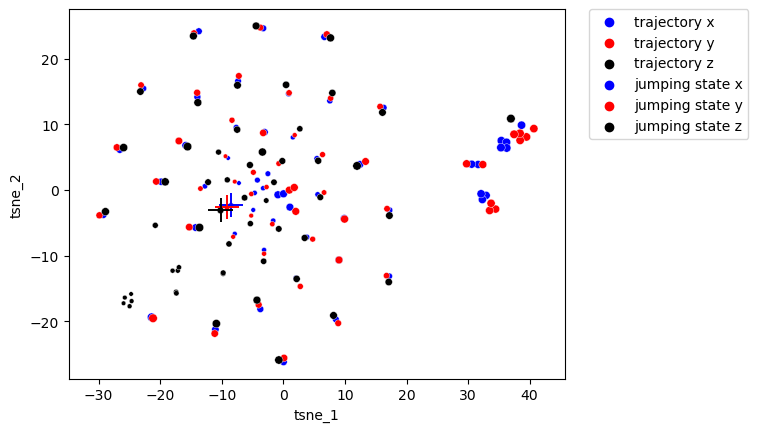

In [482]:
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=size_arr, palette=['blue','red','black'])
sns.scatterplot(data=tsne_jumping_df, x='tsne_1', y='tsne_2', ax=ax, hue='label', marker="+", s=300, palette=['blue','red','black'])
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
# ax.set_ylim(lim)
# ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)